In [1]:
!pip install -q astroquery kepler.py corner

In [2]:
%matplotlib inline

In [3]:
import pymc3 as pm
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from astropy.io import fits
from astroquery.gaia import Gaia

import corner
import kepler

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## APOGEE data

First we fetch APW's "Gold Sample" that we want to compare to.
We're going to restrict to sources with measured RV error in Gaia and quite bright.
Then we choose a random target.

In [4]:
with fits.open("https://users.flatironinstitute.org/~apricewhelan/data/dr16-binaries/gold_sample.fits") as f:
    apogee_data = f[1].data

# Bright witth RV error measured
apogee_data = apogee_data[(apogee_data["phot_g_mean_mag"] < 10) & np.isfinite(apogee_data["radial_velocity_error"])]

# Choose a random target
target = apogee_data[14]
target_num_transit = target["rv_nb_transits"]
target_sample_variance = 2 * target_num_transit * (target["radial_velocity_error"] ** 2 - 0.11 ** 2) / np.pi
print("number of transits =", target_num_transit)
print("RV sample standard deviation =", np.sqrt(target_sample_variance))

number of transits = 12
RV sample standard deviation = 12.276306396143415


## Estimate the per transit RV measurement uncertainty

We're going to estimate the RV error using a model much like Andy's trex mixture model.
First, we select some random targets close to our source in sky position, color, and magnitude:

In [5]:
columns = (
    "source_id", "ra", "dec",
    "parallax", "parallax_error",
    "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag",
    "bp_rp", "bp_g", "g_rp",
    "radial_velocity", "radial_velocity_error", "rv_nb_transits",
    "random_index", "duplicated_source",
)

query = """
SELECT  TOP 100
        {columns},
        DISTANCE(
            POINT('ICRS', ra, dec),
            POINT('ICRS', {ra}, {dec})
        ) AS dist
FROM    gaiadr2.gaia_source
WHERE   radial_velocity_error IS NOT NULL
AND     duplicated_source = 'false'
AND     rv_nb_transits >= 3
AND     phot_g_mean_mag < {max_mag}
AND     phot_g_mean_mag > {min_mag}
AND     bp_rp < {max_color}
AND     bp_rp > {min_color}
AND     1 = CONTAINS(
          POINT('ICRS', ra, dec),
          CIRCLE('ICRS', {ra}, {dec}, {radius})
        )
ORDER BY
  random_index ASC
""".format(
    columns=", ".join(columns),
    ra=target["ra"],
    dec=target["dec"],
    radius=10.0,
    min_mag=target["phot_g_mean_mag"] - 0.5,
    max_mag=target["phot_g_mean_mag"] + 0.5,
    min_color=target["bp_rp"] - 0.5,
    max_color=target["bp_rp"] + 0.5,
)
job = Gaia.launch_job_async(query)
data = job.get_results()
len(data)

INFO: Query finished. [astroquery.utils.tap.core]


100

Then we fit a model where

$$
X_n = \frac{{s_n}^2\,(T_n - 1)}{{\sigma_n}^2}
$$

is modeled as drawn from a $\chi^2$ with $T_n$ degrees of freedom.
In that equation, ${s_n}^2$ is the sample variance for target $n$ calculated from the RV "error" reported in the catalog, $T_n$ is the number of RV transits, and

$$
{\sigma_n}^2 = {\sigma_0}^2 + {\delta_n}^2
$$

Here, $\sigma_0$ is the per-transit measurement uncertainty shared across the sample and $\delta_n$ is the excess jitter for target $n$, also a parameter.

Do the MCMC:

In [6]:
num_transit = np.array(data["rv_nb_transits"])
sample_variance = 2 * num_transit * (np.array(data["radial_velocity_error"]) ** 2 - 0.11 ** 2) / np.pi

with pm.Model() as model:

    sigma0 = pm.math.exp(pm.Normal("log_sigma0", mu=0.0, sigma=10.0))
    dsigma = pm.math.exp(pm.Normal("log_dsigma", mu=0.0, sigma=10.0, shape=len(sample_variance), testval=np.sqrt(sample_variance)))
    sigma2 = sigma0 ** 2 + dsigma ** 2
    stat = sample_variance * (num_transit - 1) / sigma2

    pm.ChiSquared("obs", nu=num_transit - 1, observed=stat)

    trace = pm.sample(tune=1000, draws=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_dsigma, log_sigma0]
100%|██████████| 2000/2000 [00:18<00:00, 108.39it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


And we get an estimate of the per-transit measurement uncertainty.
This relies on the actual measurement uncertainty being the same across the sample and that at least some of the targets have no excess jitter.

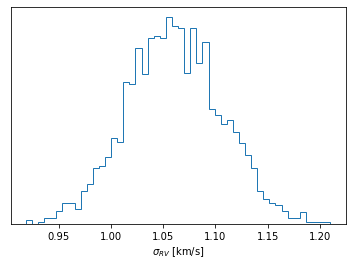

In [7]:
plt.hist(np.exp(trace["log_sigma0"]), 50, histtype="step")
plt.yticks([])
plt.xlabel(r"$\sigma_{RV}$ [km/s]");

## Fit the orbit

Then, finally, we estimate the orbital properties based on the RV error only.
Right now, I'm assuming that we don't know the transit times so our results could probably be improved.
For all the sources I've tried, the error bars on $K$ are big, but it seems to scale correctly when compared to the Joker™ values.

In [8]:
import kepler
import scipy.stats

np.random.seed(723)
n_samp = 1000000

# Simulate random transit times - I made up the number 660?
t = np.random.uniform(0, 660, (n_samp, target_num_transit))  

# Sample the measurement uncertainty from the trace
sigma = np.exp(np.random.choice(trace["log_sigma0"], size=n_samp))  

# Sample many parameters from the prior
log_period = np.random.uniform(np.log10(1.0), np.log10(5000.0), n_samp)
phase = np.random.uniform(-np.pi, np.pi, n_samp)
log_semiamp = np.random.uniform(np.log(0.1), np.log(100.0), n_samp)
ecc = np.random.uniform(0, 1, n_samp)
omega = np.random.uniform(-np.pi, np.pi, n_samp)

# Compute the Keplerian model
cosw = np.cos(omega)
sinw = np.sin(omega)
M = 2 * np.pi * t * 10 ** -log_period[:, None] + phase[:, None]
_, cosf, sinf = kepler.kepler(M, ecc[:, None] + np.zeros_like(M))
mod = np.exp(log_semiamp[:, None]) * (cosw[:, None] * (ecc[:, None] + cosf) - sinw[:, None] * sinf)

# Then compute the likelihood for each model
lam = np.sum((mod - np.mean(mod, axis=1)[:, None])**2, axis=1) / sigma ** 2
ncx2 = scipy.stats.ncx2(df=target_num_transit, nc=lam)
log_like = ncx2.logpdf((target_num_transit - 1) * target_sample_variance / sigma ** 2)

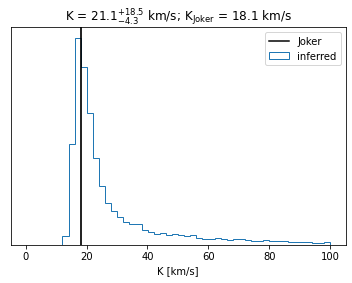

In [9]:
plt.hist(np.exp(log_semiamp), 50, weights=np.exp(log_like - log_like.max()), histtype="step", label="inferred")
plt.axvline(target["MAP_K"], color="k", label="Joker")
plt.axvline(target["MAP_K"] - target["MAP_K_err"], color="k", alpha=0.3)
plt.axvline(target["MAP_K"] + target["MAP_K_err"], color="k", alpha=0.3)
plt.yticks([])
plt.xlabel("K [km/s]")

q = corner.quantile(np.exp(log_semiamp), [0.16, 0.5, 0.84], weights=np.exp(log_like - log_like.max()))
plt.title(r"K = ${1:.1f}_{{-{2:.1f}}}^{{+{3:.1f}}}$ km/s; K$_\mathrm{{Joker}}$ = {0:.1f} km/s".format(target["MAP_K"], q[1], *np.diff(q)))

plt.legend();